# Parallelized Cubic Spline Interpolation

We recommend first working through Trajectory_tutorial.ipynb and Amplitude_tutorial.ipynb before reading this tutorial.

A part of the Fast EMRI waveforms package is parallelized cubic spline interpolation. This generally means fitting and evaluating many splines in parallel with the same input x array. This is available for GPUs and CPUs (not parallelized for CPU). The user can perform this operation entirely in Python while leveraging [CuPy](https://cupy.dev/) for GPUs. However, the evaluation will not be as efficient as when it is implemented properly in a customized kernel. The spline class ([CubicSplineInterpolant](https://bhptoolkit.org/FastEMRIWaveforms/user/sum.html#few.summation.interpolatedmodesum.CubicSplineInterpolant)) can provide an 1D flattened array of all spline coefficients for use in a custom CUDA kernel. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

# tune few configuration
cfg_set = few.get_config_setter(reset=True)

# Uncomment if you want to force CPU or GPU usage
# Leave commented to let FEW automatically select the best available hardware
#   - To force CPU usage:
# cfg_set.enable_backends("cpu")
#   - To force GPU usage with CUDA 12.x
# cfg_set.enable_backends("cuda12x", "cpu")
#   - To force GPU usage with CUDA 11.x
# cfg_set.enable_backends("cuda11x", "cpu")

cfg_set.set_log_level("info");

In [2]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux
from few.amplitude.romannet import RomanAmplitude

traj = EMRIInspiral(func=SchwarzEccFlux)
amp = RomanAmplitude()

# parameters
m1 = 1e5
m2 = 1e1
a = 0.0 # Schwarzschild as we are using SchwarzEccFlux here
p0 = 10.0
e0 = 0.7
xI = 1.0 # +1 for prograde, -1 for retrograde inspirals

# get trajectory
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(m1, m2, a, p0, e0, xI)

# The shape is (nb of data points in parameter space, mode values)
teuk_modes = amp(a, p, e, x)

In [3]:
from few.summation.interpolatedmodesum import CubicSplineInterpolant

# Let's take the amplitudes from the last step and spline those.
# For the argument of CubicSplineInterpolant, the shape of the input has to be switched.
# We will split real and imaginary components

# First argument will be the real, then imaginary mode values, and second argument the data points.
interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))

interp_in[: teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1] :, :] = teuk_modes.T.imag

spline_of_interp_in = CubicSplineInterpolant(t, interp_in)

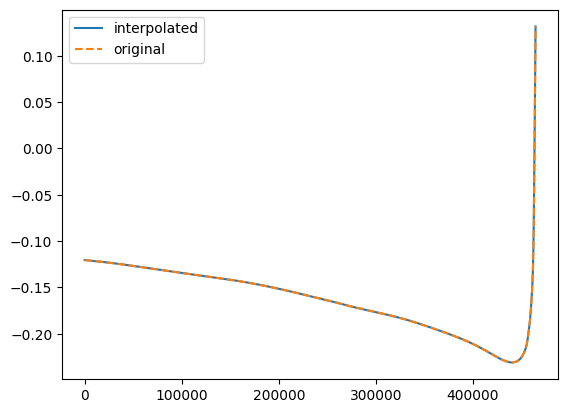

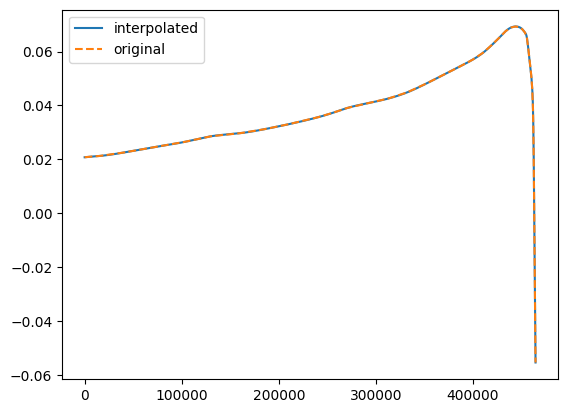

In [4]:
# Get new values
t_new = np.linspace(t[0], t[-1], 1000)

# Notice the output has the same shape as the inital input to the spline.
new_teuk_modes = spline_of_interp_in(t_new)

# To get back the original shape (with now data points at t_new), add the real and imaginary values back together and transpose
new_teuk_modes = new_teuk_modes[:teuk_modes.shape[1],:] + 1j * new_teuk_modes[teuk_modes.shape[1]:,:]; new_teuk_modes = new_teuk_modes.T

# Check the original and interpolated values for the (2,2,0,0) mode
ind = amp.special_index_map[(2, 2, 0, 0)]

plt.plot(t_new, new_teuk_modes[:,ind].real, label="interpolated")
plt.plot(t, teuk_modes[:, ind].real, "--", label="original")
plt.legend()
plt.show()

plt.plot(t_new, new_teuk_modes[:,ind].imag, label="interpolated")
plt.plot(t, teuk_modes[:, ind].imag, "--", label="original")
plt.legend()
plt.show()

To get the array of interp coefficients for CUDA implementations, do the following. The underlying shape of the array is (4, length, ninterps). It is flattened though for entry into GPU kernel. 

In [5]:
spline_of_interp_in.interp_array

array([ 6.23856751e-06,  3.56609646e-06, -1.26237401e-06, ...,
        1.24433368e-11,  1.36363437e-11,  7.04123293e-12],
      shape=(1352736,))

For convenience, the coefficients array can be returned to its original form via the `reshape_shape` attribute:


In [6]:
spline_of_interp_in.interp_array.reshape(spline_of_interp_in.reshape_shape)[0].T.shape

(7686, 44)

In [7]:
# Check
interp_in_recovered = spline_of_interp_in.interp_array.reshape(spline_of_interp_in.reshape_shape)[0].T
np.allclose(
    interp_in_recovered, 
    interp_in
    )

True